In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt

import pppc
from pppc.configs import PtychoNNTrainingConfigDict
from pppc.ptychonn.trainer import PtychoNNTrainer
from pppc.ptychonn.dataset_handle import HDF5Dataset
from pppc.ptychonn.model import PtychoNNModel, PtychoNNTransposedConvModel, PtychoNNPhaseOnlyModel
from pppc.helper import transform_data_for_ptychonn

[2024-02-12 14:28:24,453] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-02-12 14:28:24,458] NumExpr defaulting to 8 threads.


Define some data transform functions for handling raw training data with different sizes. 

In [3]:
# Raw DP size 512, label 128; crop DPs to 384, then rescale to 128. (use default function in HDF5Dataset)
transform_func_512_128 = None
transform_func_kwargs_512_128 = None

# Raw DP size 512, label 128; crop DPs to 256, then pad to 384, and rescale to 128. (use default function in HDF5Dataset)
def transform_func_512_128_pad(dp):
    dp = transform_data_for_ptychonn(dp, target_shape=(256, 256), discard_len=(128, 128))
    dp = transform_data_for_ptychonn(dp, target_shape=(128, 128), discard_len=(-64, -64))
    return dp
transform_func_kwargs_512_128_pad = None

In [4]:
decimate_ratio_list = [0.1, 0.05, 0.02, 0.01, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#decimate_ratio_list = [0.1, 0.05, 0.02, 0.01]

dataset = HDF5Dataset('data/data_train_meanSubStdData.h5', verbose=False, 
                      transform_func=None, transform_func_kwargs=None, standardized=True)

for decimate_ratio in decimate_ratio_list:
    config_dict = PtychoNNTrainingConfigDict(
        dataset_decimation_ratio=decimate_ratio,
        batch_size_per_process=64,
        num_epochs=60,
        learning_rate_per_process=1e-4,
        optimizer='adam',
        model_save_dir='../../trained_models/model_phaseOnly_BN_36SpiralDatasets_meanSubStdData_dataDecimation_{}'.format(decimate_ratio),
        validation_ratio=0.1,
        dataset=dataset,
        model=(PtychoNNPhaseOnlyModel, {'use_batchnorm': True}),
        debug=False
    )
    
    trainer = PtychoNNTrainer(config_dict)
    trainer.build(seed=196)
    
    trainer.run_training()

[2024-02-12 14:28:26,389] Decimating dataset to 0.1 of the original size...
[2024-02-12 14:28:26,535] Using DataParallel with 2 devices.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.16it/s]
[2024-02-12 14:28:40,681] Saving improved model after Val Loss improved from inf to 0.67778
[2024-02-12 14:28:40,777] Epoch: 0 | FT  | Train Loss: 0.72265 | Val Loss: 0.67778
[2024-02-12 14:28:40,778] Epoch: 0 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
[2024-02-12 14:28:40,779] Epoch: 0 | Ph  | Train Loss: 0.723 | Val Loss: 0.678
[2024-02-12 14:28:40,780] Epoch: 0 | Ending LR: 0.000050 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.42it/s]
[2024-02-12 14:28:52,559] Saving improved model after Val Loss improved from 0.67778 to 0.57672
[2024-02-12 14:28:

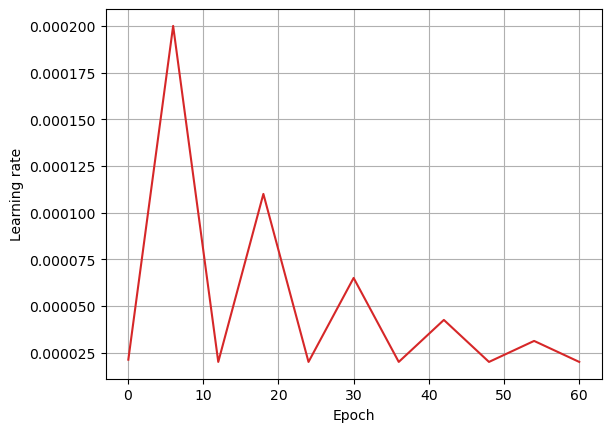

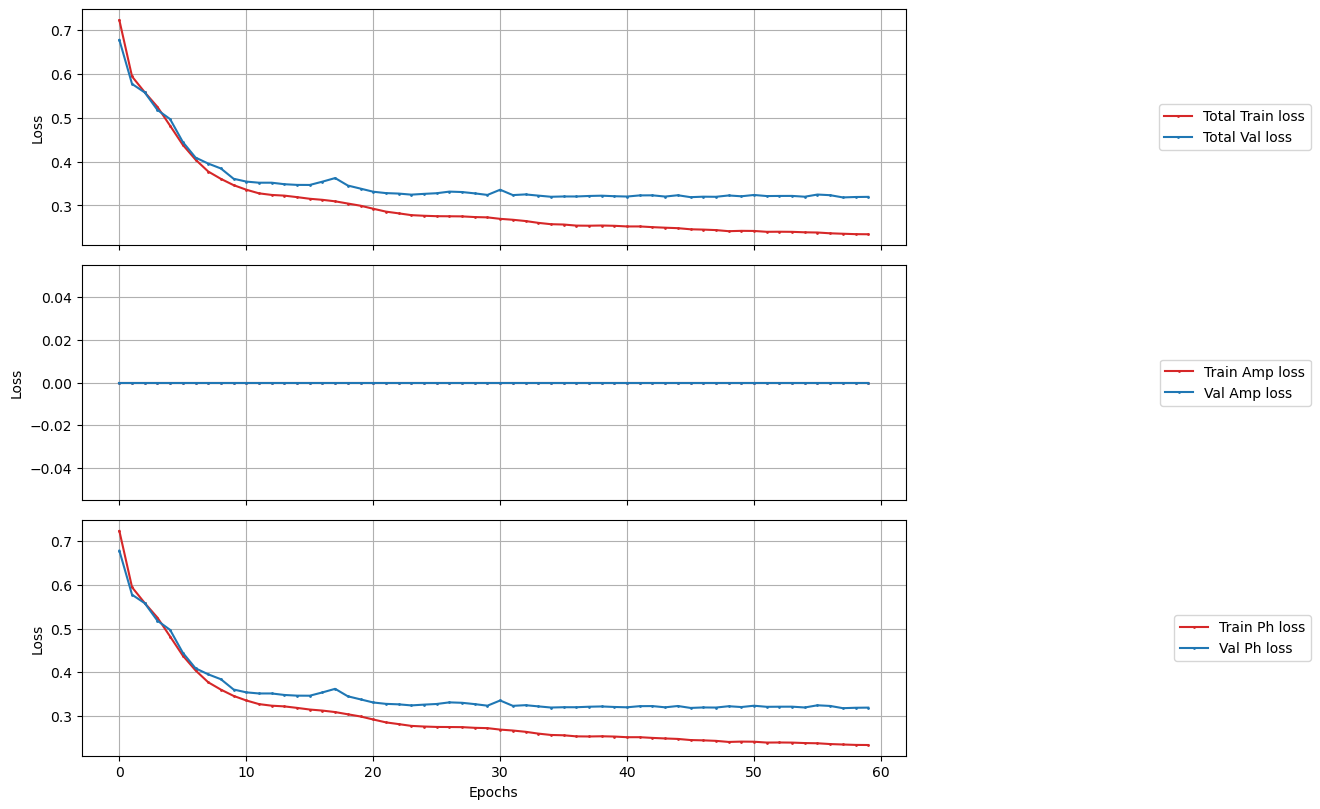

In [5]:
trainer.plot_training_history()